# Solving the Minimum Vertex Cover Problem

In this notebook, we will describe how to solve the **Minimum Vertex Cover** problem with LunaSolve. We will begin by defining, explaining and giving an example for the Minimum Vertex Cover problem. We will then continue by modeling a problem instance, optimize it and implement the solution using LunaSolve. Finally, we will also take a further look at the interpretation of the answer we are returned from Luna.


## Table of Contents

1. [Introduction](#1)
2. [Real World Example](#2)
3. [Solving the Minimum Vertex Cover problem with Luna](#3)



<a id="1"></a>
## 1. Introduction

## **Minimum Vertex Cover** 
The Minimum Vertex Cover problem is an important problem in graph theory. It seeks to identify the smallest subset of vertices (nodes) within a graph such that every edge (connection) between pairs of vertices is covered by at least one of those vertices. This problem has numerous practical applications, including ensuring network security and optimizing resource allocation.

If we want to define the problem formally, let first $G = (V, E)$ be an undirected graph. A *vertex cover* is then a subset of vertices $C \subseteq V$ such that for every edge $(u, v) \in E$, at least one of $u$ or $v$ is in $C$. The Minimum Vertex Cover problem is to find such a subset $C$ of minimal size, that is, to minimize $|C|$ while ensuring all edges are covered.


<a id="2"></a>
## 2. Description

Let’s break down the problem through a practical example. Imagine you’re in charge of a network of computers, and each connection between two computers can be exploited as a potential weakness. To keep the network safe, you need to monitor some of the computers (vertices), so that every connection (edge) is covered. The tricky part is finding the fewest computers to keep an eye on while still covering all the connections.

This is exactly what the Minimum Vertex Cover problem is about. Its goal is to find the smallest group of vertices (computers) that cover every connection (edge) in the network (graph).

Next we`ll construct a graph representing a network of computers. Assume we have 10 computers, and each computer is represented by a node, and the edges between the nodes represent connections. We can easily model this problem in Python using the networkx package and visualize it with the matplotlib library.

<a id="3"></a>
## 3. Solving the Minimum Vertex Cover problem with Luna

To follow along with the next steps, three libraries are needed:
1. **luna-quantum** for encoding and solving our optimization problem,  
2. **matplotlib** for visualization, and  
3. **networkx** for creating and drawing the graph.  

The cell below installs these packages for you if they are not already installed.

In [1]:
# Install dependencies
%pip install --upgrade pip
%pip install luna-quantum --upgrade
%pip install matplotlib networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 3.1 Set up Luna Client
Now, let's walk through the implementation of the Minimum Vertex Cover problem using LunaSolve. First, create an encryption key. You can generate a key [here](https://docs.aqarios.com/get-started#luna-encryption).

In [2]:
import os
os.environ["LUNA_ENCRYPTION_KEY"] = "gzaUL8hDECWXRcGrJiEa5wVWVgt4sgPbBDjKN8I92ps"

As the next step, instantiate a LunaSolve object and set your credentials. The API key is needed to identify you and grant access to the Luna platform. You can find it in your Aqarios account settings.

In [3]:
from luna_sdk import LunaSolve
ls = LunaSolve(api_key="60360df4e8b54305aababfa6ac99429e")

### 3.2 Create a Minimum Vertex Cover problem

To create a Minimum Vertex Cover instance, any graph with vertices and edges is sufficient. In this notebook, we will create one representing the network of 10 computers, labeled from 0 to 9. Each computer is a node of the graph. Some computer pairs are connected in the network. A connection is expressed through an edge connecting the two nodes representing the pair of computers. 

After defining the graph, we will visualize it for better comprehension.

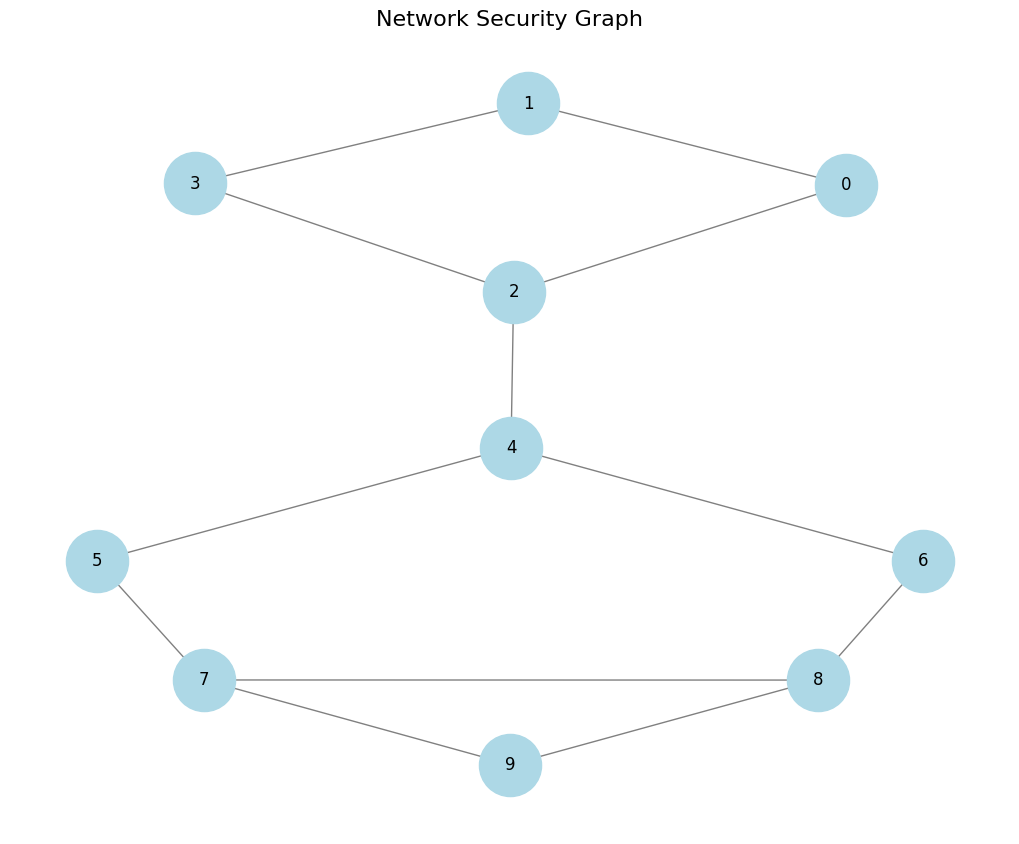

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
mvc_graph = nx.Graph()

# Add nodes (computers)
computers = list([f"{i}" for i in range(10)])
mvc_graph.add_nodes_from(computers)

# Add edges (connections)
connections = [
    ("0", "1"),
    ("0", "2"),
    ("1", "3"),
    ("2", "3"),
    ("2", "4"),
    ("4", "5"),
    ("4", "6"),
    ("5", "7"),
    ("6", "8"),
    ("7", "8"),
    ("7", "9"),
    ("8", "9")
]
mvc_graph.add_edges_from(connections)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(mvc_graph, seed=42)
nx.draw(
    mvc_graph, pos, with_labels=True, node_size=2000, font_size=12, 
    node_color="lightblue", font_color="black", edge_color="gray"
)
plt.title("Network Security Graph", fontsize=16)
plt.show()

Now we can visualize all computers (nodes) and their respective connections. We will now try to find the minimum number of computers which have to be observed, in order for all network connections to be securely overwatched.

### 3.3 Creating a Minimum Vertex Cover Object
To find the smallest subset of nodes that cover all edges using LunaSolve, we define the Minimum Vertex Cover use case using Luna’s `MinimumVertexCover` class. This class converts the computer network graph into a QUBO optimization problem, which Luna can then optimize.

In [5]:
# import the MinimumVertexCover object from the luna sdk
from luna_sdk.schemas import MinimumVertexCover

# create a MinimumVertexCover object
mvc = MinimumVertexCover(graph=nx.to_dict_of_dicts(mvc_graph))


### 3.4 Create Luna Optimization

We can now upload the problem instance as an optimization to Luna and solve it afterwards.

In [6]:
optimization = ls.optimization.create_from_use_case(name="MVC", use_case=mvc)

### 3.5 Create a Luna Solution

The next step involves creating a job, which is an outbound request to the hardware provider to solve the optimisation problem. By calling the `ls.solution.create()` method of LunaSolve we can create the outbound job. This method takes care of optimizing our problem. To solve the Max Independent Set problem, we pass the `optimization_id` from our optimisation object of our use case, specify the `solver_name` we choose, the `provider` of the computing hardware, `solver_parameters` (which may be specific to the solver), and a `qpu_token` if needed.

In this instance, we solve the Max Independent Set problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider.

In [7]:
job = ls.solution.create(
    optimization_id=optimization.id,
    solver_name="sa",
    provider="dwave",
    solver_parameters={}
)

### 3.6 Retrieve the Solution

In step 3.4, we uploaded the problem, and in 3.5, we made a solve request to Luna. Luna sends the optimisation problem to the provider specified and is returned a solution. Luna autonomously takes care of all background activities, during which the user can turn to other of their important matters. The background processes include the creation and translation of the optimisation problem for the according hardware provider, sending out the request and obtaining a result back, and translating the solution back to an interpretable format.

The `Solution` object created, has multiple attributes expressing different factors of the optimisation problem. These include meta data of the optimisation and the sampled results. The optimisation meta data includes information attached to the use case problem, such as `id`, `name`, `solver`and `provider` names, `runtime` and `qpu` type. Lastly, the `status` variable indicates if the job has been successfully executed and returned to Luna. If the status variable says DONE, the optimisation has finished. In the case REQUESTED is displayed for the status, your optimisation is still being processed. Wait a little bit and re-execute the cell, to retrieve the updated solution.

In [8]:
solution = ls.solution.get(solution_id=job.id)
print(solution)


id: 67b5f7bcc9719a8b4fb0af0b
name: None
status: REQUESTED
solver: SA
provider: dwave
runtime: None
optimization_name: QUBO_MATRIX
created_date: 2025-02-19 15:24:44 (+07)
results:
    No results..
    Solution has status: REQUESTED



Because we converted the use case into the QUBO format, the solution we are returned from our provider is also in this format, which typically is in a vectorised form. However, the encoding from our original optimisation problem might be different. Slack variables, linearisations and transformations between optimisation formats can alter the variable description of optimisation methods. As aforementioned, Luna performs a post-processing step which transforms the solution from the QUBO domain back to a more intuitive domain. 

The `ls.solution.get_use_case_representation(solution_id=job.id)` method transforms the solution of our optimisation to a readable format. The `sense`attribute informs us if we are trying to maximize or minimize our objective function. The `result` is typically given as an iterable containing the `representation` which contains the solution, and the `òbj_value`. The objective value is difficult to interpret as it encompasses both optimization values and constraint penalties, however smaller values express better solutions. The `description` explains the encoding of the `representation` of the result. 

The formal definition of the Minimum Vertex Cover problem is intuitive. The variables $x_i$ encode the values given to the nodes of the graph as they are also encoded in the `nx.to_dict_of_dicts(mvc_graph)` dictionary. If the value is equal to one, it means that the node (computer) is part of the smallest cover (should be monitored to maximize security while minimizing effort), while zero means that the node is not part of the smallest cover.

Accordingly, in the case of the Minimum Vertex Cover problem, the representation is a list which contains the indices of all nodes that are included in the smallest cover. In other words, the representation is a list of all indices $i$, for which their decision variable $x_i$ is equal to one. 

In [9]:
use_case_repr = ls.solution.get_use_case_representation(job.id)
print(use_case_repr)

sense: min
results: [{'representation': [1, 2, 4, 5, 7, 8], 'obj_value': -90.0}]
description: List of node indices that are part of the weighted vertex cover.



Finally, if we wish to see the best solution from all evaluated samples we can call the `ls.solution.get_best_use_case_result(use_case_representation=use_case_repr)` method.

In [10]:
best_solution = ls.solution.get_best_use_case_result(use_case_repr)
print(best_solution)

representation=[1, 2, 4, 5, 7, 8] obj_value=-90.0


To better grasp the solution, we can visualize again the computer network using the graph we created, and colour all nodes which have a value of 0 red and all others that are 1, green.

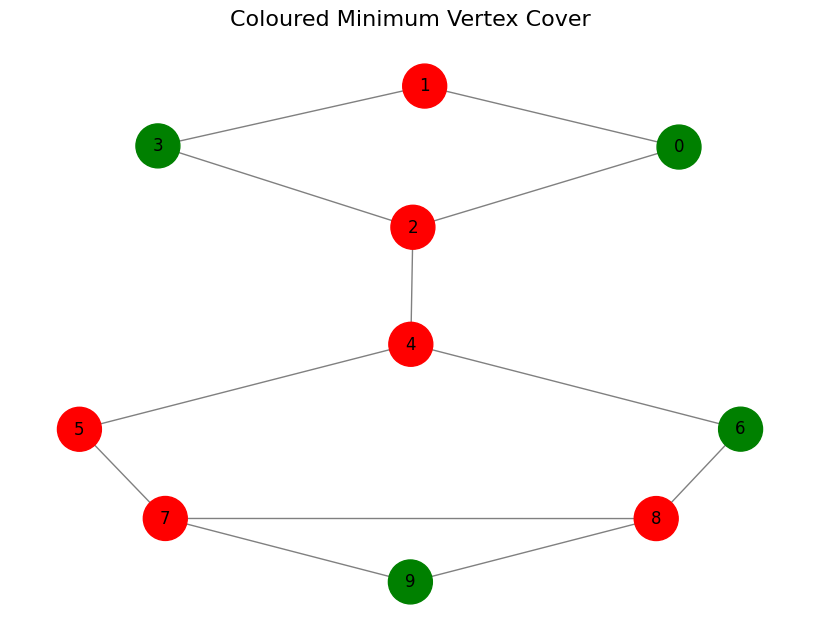

In [11]:
colour_list = []
for node in mvc_graph.nodes:
    if int(node) in best_solution.representation:
        colour_list.append("red")
    else:
        colour_list.append("green")

# Draw the graph with new coloring
plt.figure(figsize=(8, 6))
nx.draw(mvc_graph, pos, with_labels=True, node_color=colour_list, edge_color="gray", node_size=1000, font_size=12)
plt.title("Coloured Minimum Vertex Cover", fontsize=16)
plt.show()